## CS 445: Computational Photography

## Programming Project #3: Gradient Domain Fusion

In [13]:
# from google.colab import drive
# drive.mount('/content/drive')

## Part 1 Toy Problem (20 pts)

In [39]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from random import random
import time
import scipy
import scipy.sparse.linalg

# modify to where you store your project data including utils.py
datadir = "./" 

utilfn = datadir + "utils.py"
!cp "$utilfn" .
samplesfn = datadir + "samples"
!cp -r "$samplesfn" .
import utils


cp: './utils.py' and './utils.py' are the same file
cp: './samples' and './samples' are the same file


In [78]:
def toy_reconstruct(img):
    """
    The implementation for gradient domain processing is not complicated, but it is easy to make a mistake, so let's start with a toy example. Reconstruct this image from its gradient values, plus one pixel intensity. 
    Denote the intensity of the source image at (x, y) as s(x,y) and the value to solve for as v(x,y). For each pixel, then, we have two objectives:
    1. minimize (v(x+1,y)-v(x,y) - (s(x+1,y)-s(x,y)))^2
    2. minimize (v(x,y+1)-v(x,y) - (s(x,y+1)-s(x,y)))^2
    Note that these could be solved while adding any constant value to v, so we will add one more objective:
    3. minimize (v(1,1)-s(1,1))^2

    The first step is to write the objective function as a set of least squares constraints in the standard matrix form: (Av-b)^2. Here, "A" is a sparse matrix, "v" are the variables to be solved, and "b" is a known vector. 
    Especially for blending with irregular masks, it is helpful to keep a matrix im2var that maps each pixel to a variable number, such as:
    
    im_h, im_w = im.shape
    im2var = np.arange(im_h * im_w).reshape(im_h, im_w)
    
    Then, you can write objective 1 above as:
    e = e + 1;
    A[e][im2var[y][x+1]] = 1
    A[e][im2var[y][x]] = -1
    b[e] = im[y][x+1] - im[y][x]
    Here, "e" is used as an equation counter. Note that the y-coordinate is the first index. As another example, objective 3 above can be written as:
    e = e + 1;
    A[e][im2var[0][0]] = 1
    b[e] = s[0][0]
    
    To solve for v, use v = scipy.sparse.linalg.lsqr(A, b); Then, copy each solved value to the appropriate pixel in the output image.
    
    :param toy_img: numpy.ndarray
    """

    # alright, so what do we want to do, in simple terms?

    # We need to figure out A and b, then use them to solve for v

    # A is going to be our gradient matrix: capturing the gradients from the source pixels in relation to their neighbors in a specific way
    # b is going to be what we want our gradient to actually equal
    # that leaves v, which are the pixel values that are applied to our gradient matrix in order to return b. Av = b

    # we need a mapping vector. This will be in the shape of our image but just count from 0 to total # of pixels
    im_h, im_w = img.shape
    im2var = np.arange(im_h * im_w).reshape(im_h, im_w)

    num_equations = ((im_h-1) * im_w)*2 # in gradient domain processing, each pixel will require 2 equations. Thus the # of equations needed = # of pixels * 2
    total_vars = im_h * im_w            # Number of variables in v. These are the pixel values, so we need a variable for every pixel we are solving for
    
    A = sp.lil_matrix((num_equations, total_vars)) # create zero matrices for A and b
    b = np.zeros(num_equations)

    # now, it is time to fill A and b

    # objective 1: horizontal gradients
    
    e = 0  # Initialize equation index
    
    for y in range(im_h):                     # Iterate over the rows
        for x in range(im_w - 1):             # Iterate over columns, excluding the last column as it has no gradient
            A[e, im2var[y, x + 1]] = 1        # Positive contribution from the pixel to the right
            A[e, im2var[y, x]] = -1           # Negative contribution from the pixel to the left
            b[e] = img[y, x + 1] - img[y, x]  # Fill in the target difference for the gradient
            e += 1                            # Increment the equation number for each gradient equation
            
    for y in range(im_h - 1):                 # Iterate over rows, excluding the last row
        for x in range(im_w):                 # Iterate over all columns
            A[e, im2var[y + 1, x]] = 1        # Positive contribution from the pixel below
            A[e, im2var[y, x]] = -1           # Negative contribution from the pixel above
            b[e] = img[y + 1, x] - img[y, x]  # Fill in the target difference for the gradient
            e += 1                            # Increment the equation number for each gradient equation
    
    A[e][im2var[0][0]] = 1  # Set the coefficient for v[0][0] to 1
    b[e] = s[0][0]          # Set the target value from the source image
    e += 1                  # Move to the next equation
    
    # solve for v
    v = scipy.sparse.linalg.lsqr(A, b)[0]  # Retrieve the solution vector

    return v.reshape(im_h, im_w)           # Reshape the flattened array back to the original image dimensions

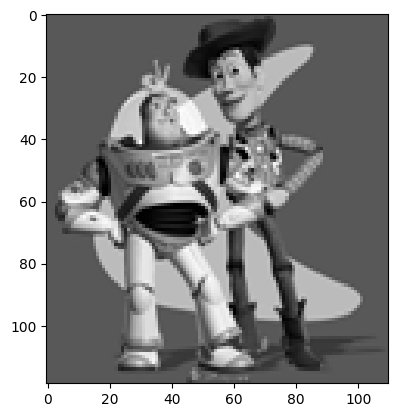

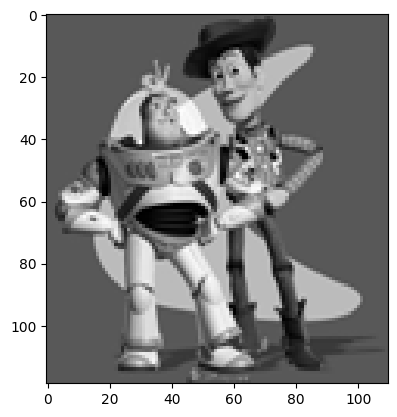

Max error is:  0.42705325760887347


In [80]:
toy_img = cv2.cvtColor(cv2.imread('samples/toy_problem.png'), cv2.COLOR_BGR2GRAY).astype('double') / 255.0
plt.imshow(toy_img, cmap="gray")
plt.show()

im_out = toy_reconstruct(toy_img)
plt.imshow(im_out, cmap="gray")
plt.show()
print("Max error is: ", np.sqrt(((im_out - toy_img)**2).max()))

## Preparation

In [ ]:
background_img = cv2.cvtColor(cv2.imread('samples/im2.JPG'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.figure()
plt.imshow(background_img)
plt.show()
object_img = cv2.cvtColor(cv2.imread('samples/penguin-chick.jpeg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.imshow(object_img)
plt.show()

use_interface = False  # set to true if you want to use the interface to choose points (might not work in Colab)
if not use_interface:
  xs = (65, 359, 359, 65)
  ys = (24, 24, 457, 457)
  object_mask = utils.get_mask(ys, xs, object_img)
  bottom_center = (500, 2500) # (x,y)

  object_img, object_mask = utils.crop_object_img(object_img, object_mask)
  bg_ul = utils.upper_left_background_rc(object_mask, bottom_center)
  plt.imshow(utils.get_combined_img(background_img, object_img, object_mask, bg_ul))



In [ ]:
if use_interface:
  import matplotlib.pyplot as plt
  %matplotlib notebook
  mask_coords = specify_mask(object_img)

In [ ]:
if use_interface:
  xs = mask_coords[0]
  ys = mask_coords[1]
  %matplotlib inline
  import matplotlib.pyplot as plt
  plt.figure()
  object_mask = get_mask(ys, xs, object_img)

In [ ]:
if use_interface:
  %matplotlib notebook
  import matplotlib.pyplot as plt
  bottom_center = specify_bottom_center(background_img)
  %matplotlib inline
  import matplotlib.pyplot as plt

  object_img, object_mask = utils.crop_object_img(object_img, object_mask)
  bg_ul = utils.upper_left_background_rc(object_mask, bottom_center)
  plt.imshow(utils.get_combined_img(background_img, object_img, object_mask, bg_ul))



## Part 2 Poisson Blending (50 pts)

In [ ]:
def poisson_blend(object_img, object_mask, bg_img, bg_ul):
    """
    Returns a Poisson blended image with masked object_img over the bg_img at position specified by bg_ul.
    Can be implemented to operate on a single channel or multiple channels
    :param object_img: the image containing the foreground object
    :param object_mask: the mask of the foreground object in object_img
    :param background_img: the background image 
    :param bg_ul: position (row, col) in background image corresponding to (0,0) of object_img 
    """
    #TO DO 



In [ ]:
im_blend = np.zeros(background_img.shape)
for b in np.arange(3):
  im_blend[:,:,b] = poisson_blend(object_img[:,:,b], object_mask, background_img[:,:,b].copy(), bg_ul)

plt.figure(figsize=(15,15))
plt.imshow(im_blend)

## Part 3 Mixed Gradients (20 pts)

In [ ]:
def mixed_blend(object_img, object_mask, bg_img, bg_ul):
    """
    Returns a mixed gradient blended image with masked object_img over the bg_img at position specified by bg_ul.
    Can be implemented to operate on a single channel or multiple channels
    :param object_img: the image containing the foreground object
    :param object_mask: the mask of the foreground object in object_img
    :param background_img: the background image 
    :param bg_ul: position (row, col) in background image corresponding to (0,0) of object_img 
    """
    #TO DO 



In [ ]:
im_mix = np.zeros(background_img.shape)
for b in np.arange(3):
  im_mix[:,:,b] = mixed_blend(object_img[:,:,b], object_mask, background_img[:,:,b].copy(), bg_ul)

plt.figure(figsize=(15,15))
plt.imshow(im_mix)

# Bells & Whistles (Extra Points)

## Color2Gray (20 pts)

In [ ]:
def color2gray(img):
    pass

## Laplacian pyramid blending (20 pts)

In [ ]:
def laplacian_blend(object_img, object_mask, bg_img, bg_ul):
  # feel free to change input parameters
    pass

## More gradient domain processing (up to 20 pts)